##**Collaborative Filtering**  

# Import Library

pada bagian ini akan dilakukan import library yang akan digunakan untuk keseluruhan proyek ini

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

- Ini adalah proses load data, mengambil data yang telah diunduh dari platform kaggle
- Link dataset : https://www.kaggle.com/datasets/aprabowo/indonesia-tourism-destination

In [31]:
# Load Data
rate = pd.read_csv('/content/tourism_rating.csv')
point = pd.read_csv('/content/tourism_with_id.csv')
user = pd.read_csv('/content/user.csv')


# Praproses

In [32]:
rate.columns

Index(['User_Id', 'Place_Id', 'Place_Ratings'], dtype='object')

In [33]:
point.columns

Index(['Place_Id', 'Place_Name', 'Description', 'Category', 'City', 'Price',
       'Rating', 'Time_Minutes', 'Coordinate', 'Lat', 'Long', 'Unnamed: 11',
       'Unnamed: 12'],
      dtype='object')

In [34]:
user.columns

Index(['User_Id', 'Location', 'Age'], dtype='object')

- Proses untuk mengecek nilai null pada data rate

In [35]:
rate.isnull().sum()

,0
User_Id,0
Place_Id,0
Place_Ratings,0


- proses pengecekan nilai duplikat pada data rate

In [36]:
rate.duplicated().sum()

np.int64(79)

- penghapusan baris yang duplikat pada data rate

In [37]:
# Drop duplikat rating
rate = rate.drop_duplicates()

In [38]:
point = point.drop(columns=['Unnamed: 11','Unnamed: 12'])

Proses melakukan visualisasi untuk melihat sebaran tempat destinasi berdasarkan rating terbanyak

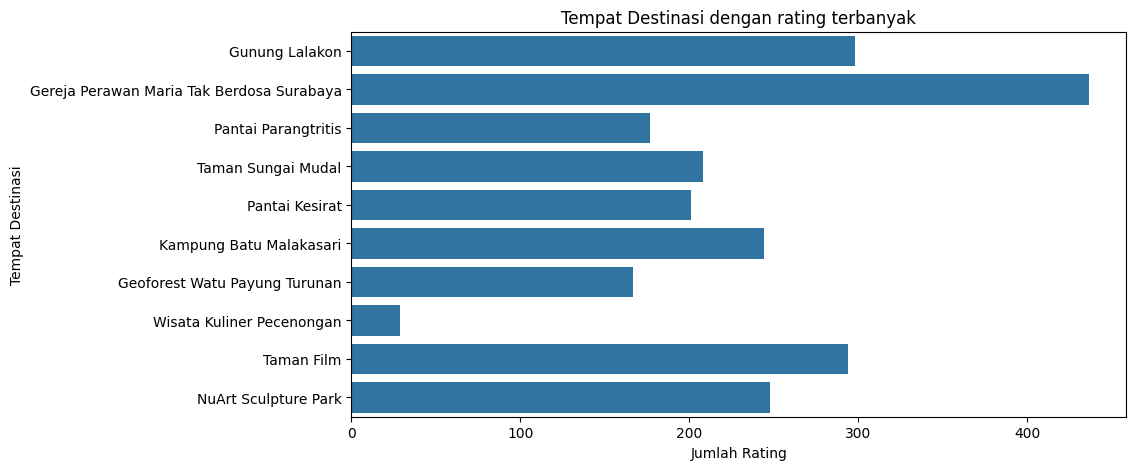

In [39]:
bigten = rate['Place_Id'].value_counts().reset_index()[0:10]
bigten = pd.merge(bigten, point[['Place_Id', 'Place_Name']], how='left', left_on='Place_Id', right_on='Place_Id')
plt.figure(figsize=(10,5))
sns.barplot(x='Place_Id', y='Place_Name', data=bigten)
plt.title('Tempat Destinasi dengan rating terbanyak')
plt.ylabel('Tempat Destinasi')

plt.xlabel('Jumlah Rating')
plt.show()

Tahapan melihat visualisasi sebaran tempat destinasi berdasarkan kategori untuk melihat mana yang lebih banyak

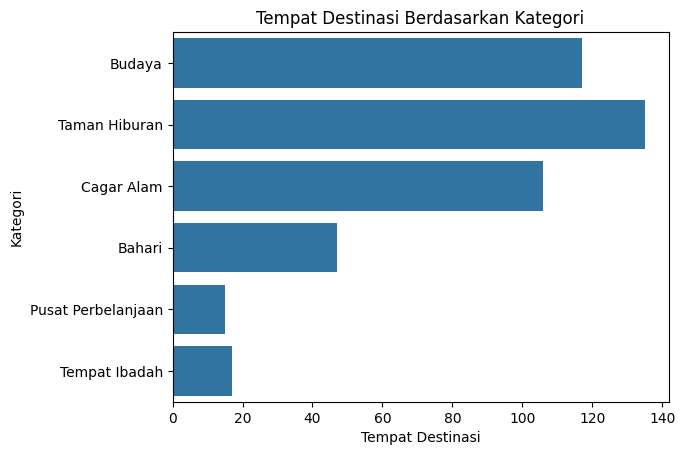

In [40]:
sns.countplot(y='Category', data=point)
plt.title('Tempat Destinasi Berdasarkan Kategori')
plt.ylabel('Kategori')
plt.xlabel('Tempat Destinasi')
plt.show()

Bagian untuk melihat umur pengguna pada data

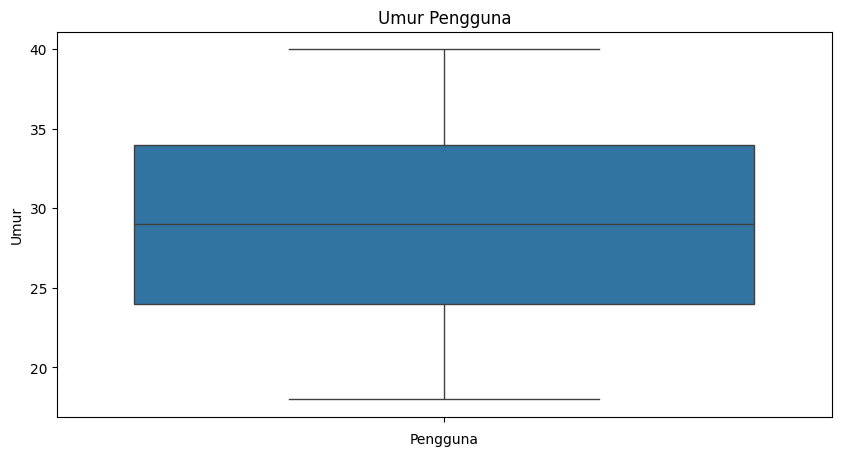

In [41]:
plt.figure(figsize=(10,5))
sns.boxplot(user['Age'])
plt.title('Umur Pengguna')
plt.ylabel('Umur')
plt.xlabel('Pengguna')
plt.show()

Bagian untuk melihat sebaran harga masuk destinasi

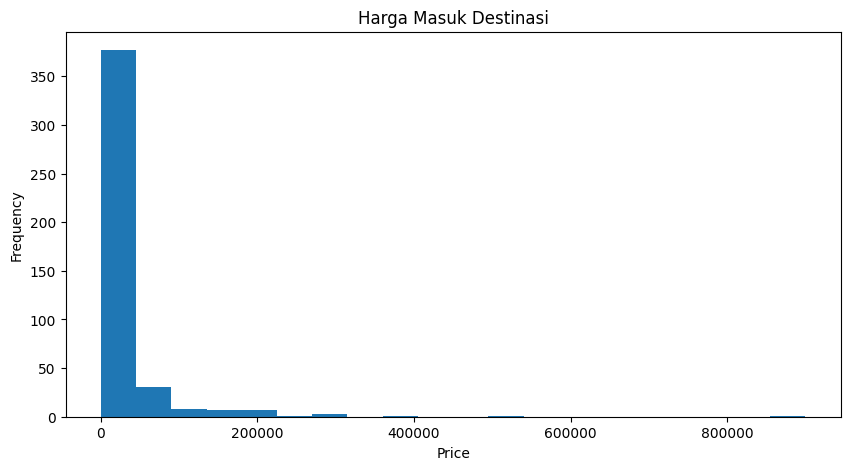

In [42]:
plt.figure(figsize=(10,5))
plt.hist(point['Price'],bins=20)
plt.xlabel('Price')
plt.ylabel("Frequency")
plt.title('Harga Masuk Destinasi')
plt.show()

Melihat visualisasi dari persebaran lokasi pengguna yang ada di dalam dataset

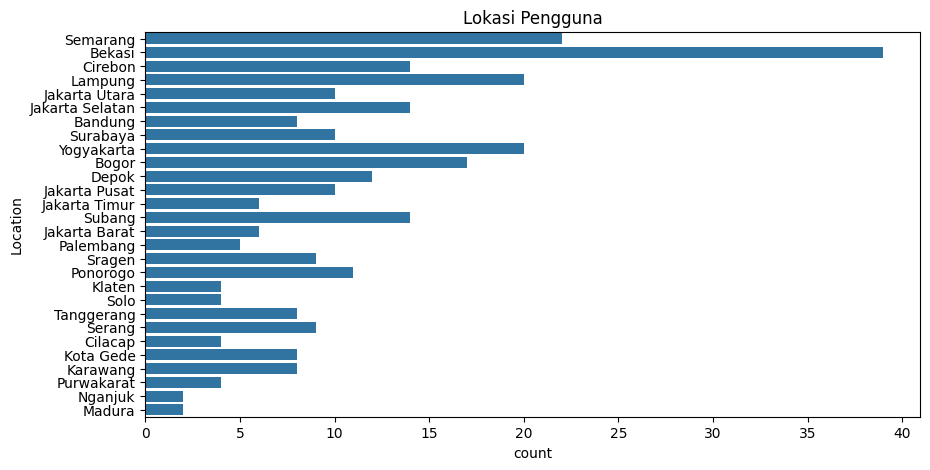

In [43]:
lokasi = user['Location'].apply(lambda x: x.split(',')[0])
plt.figure(figsize=(10,5))
sns.countplot(y=lokasi)
plt.title('Lokasi Pengguna')
plt.show()

Karena basisnya sekarang ingin terfokus pada daerah Yogyakarta saja maka dilakukan filtering untuk mengambil data hanya dari daerah yogyakarta saja

In [44]:
# Filter destinasi hanya dari Yogyakarta
point = point[point['City'] == 'Yogyakarta']
rate = pd.merge(rate, point[['Place_Id']], how='right', on='Place_Id')

In [45]:
point.shape

(126, 11)

Melihat sebaran dari tempat destinasi dengan rating terbanyak di jogja

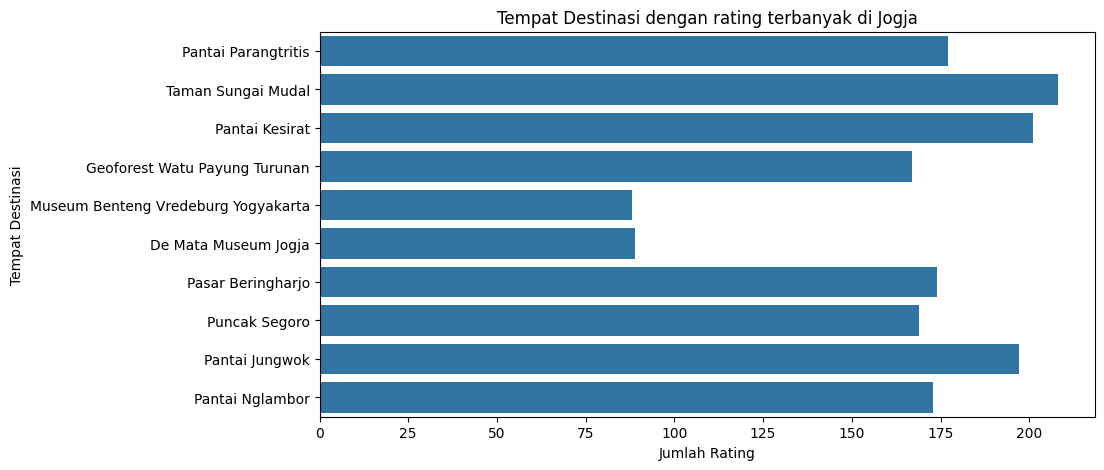

In [46]:
jogja = rate['Place_Id'].value_counts().reset_index()[0:10]
jogja = pd.merge(jogja, point[['Place_Id', 'Place_Name']], how='left', left_on='Place_Id', right_on='Place_Id')
plt.figure(figsize=(10,5))
sns.barplot(x='Place_Id', y='Place_Name', data=jogja)
plt.title('Tempat Destinasi dengan rating terbanyak di Jogja')
plt.ylabel('Tempat Destinasi')

plt.xlabel('Jumlah Rating')
plt.show()

Melihat visualisasi tempat destinasi di jogja berdasarkan kategori

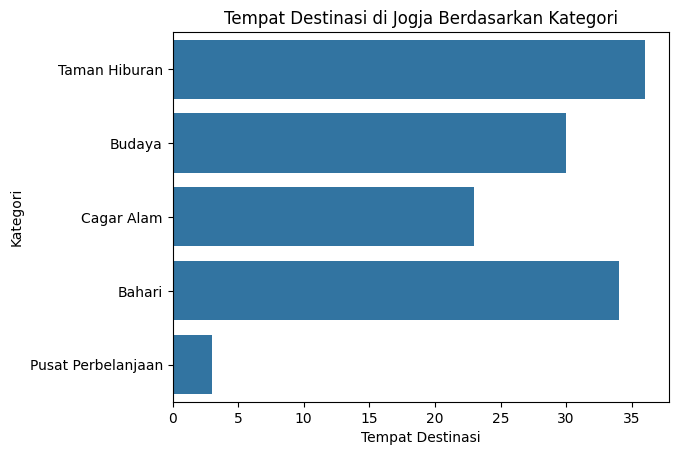

In [47]:
sns.countplot(y='Category', data=point)
plt.title('Tempat Destinasi di Jogja Berdasarkan Kategori')
plt.ylabel('Kategori')
plt.xlabel('Tempat Destinasi')
plt.show()

Melihat visualisasi dari harga masuk destinasi di jogja

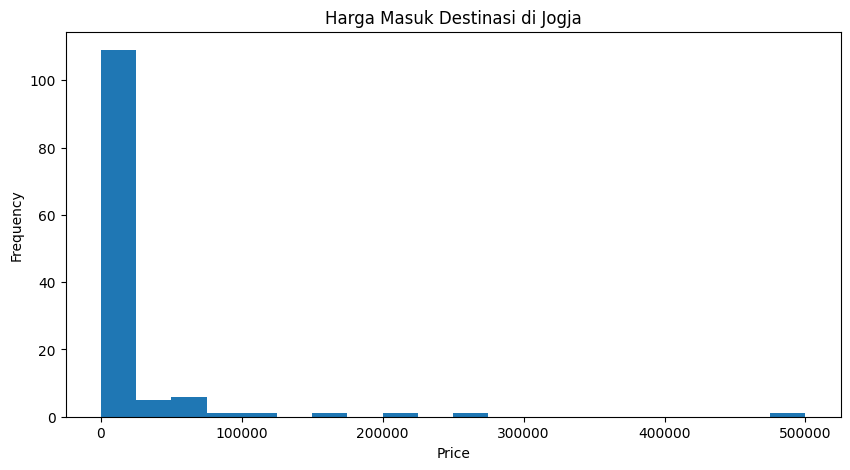

In [48]:
plt.figure(figsize=(10,5))
plt.hist(point['Price'],bins=20)
plt.xlabel('Price')
plt.ylabel("Frequency")
plt.title('Harga Masuk Destinasi di Jogja')
plt.show()

dilakukan proses mengubah kolom User_Id dan Place_Id dari data asli menjadi bentuk numerik (integer) yang dapat diproses oleh model machine learning atau deep learning untuk keperluan sistem rekomendasi.

In [49]:
# Membuat mapping ID
user_ids = rate['User_Id'].unique().tolist()
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded_to_user = {i: x for x, i in user_to_user_encoded.items()}

place_ids = rate['Place_Id'].unique().tolist()
place_to_place_encoded = {x: i for i, x in enumerate(place_ids)}
place_encoded_to_place = {i: x for x, i in place_to_place_encoded.items()}


dilakukan proses menambahkan dua kolom baru pada DataFrame rate, yaitu kolom user dan place, yang berisi hasil encoding dari User_Id dan Place_Id menggunakan dictionary mapping yang telah dibuat sebelumnya (user_to_user_encoded dan place_to_place_encoded)

In [50]:
# Tambahkan kolom encoded
rate['user'] = rate['User_Id'].map(user_to_user_encoded)
rate['place'] = rate['Place_Id'].map(place_to_place_encoded)

num_users = len(user_ids)
num_place = len(place_ids)

dilakukan normalisasi terhadap kolom Place_Ratings dalam DataFrame rate ke dalam rentang 0 hingga 1 agar skala data lebih seragam

In [51]:
# Normalisasi rating ke 0-1
min_rating = min(rate['Place_Ratings'])
max_rating = max(rate['Place_Ratings'])
rate['normalized_rating'] = rate['Place_Ratings'].apply(lambda x: (x - min_rating) / (max_rating - min_rating))


proses pembagian data latih dan data uji

In [52]:
# Siapkan data training
x = rate[['user', 'place']].values
y = rate['normalized_rating'].values

# Split train/val
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)


# Modelling

Proses melatih sebuah model rekomendasi berbasis neural network menggunakan TensorFlow dan Keras. Model RecommenderNet adalah subclass dari tf.keras.Model yang memanfaatkan layer embedding untuk merepresentasikan pengguna dan tempat (user dan place) dalam vektor berdimensi rendah (embedding_size).

In [53]:
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_places, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.user_embedding = layers.Embedding(num_users, embedding_size, embeddings_initializer='he_normal',
                                               embeddings_regularizer=keras.regularizers.l2(1e-6))
        self.user_bias = layers.Embedding(num_users, 1)
        self.places_embedding = layers.Embedding(num_places, embedding_size, embeddings_initializer='he_normal',
                                                 embeddings_regularizer=keras.regularizers.l2(1e-6))
        self.places_bias = layers.Embedding(num_places, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        places_vector = self.places_embedding(inputs[:, 1])
        places_bias = self.places_bias(inputs[:, 1])
        dot_user_places = tf.reduce_sum(user_vector * places_vector, axis=1, keepdims=True)
        x = dot_user_places + user_bias + places_bias
        return tf.nn.sigmoid(x)

model = RecommenderNet(num_users, num_place, 50)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=keras.optimizers.Adagrad(learning_rate=0.0003),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_root_mean_squared_error') < 0.25:
            print('\nRoot metrics validasi sudah sesuai harapan')
            self.model.stop_training = True

history = model.fit(
    x=x_train,
    y=y_train,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[myCallback()]
)




Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.6952 - root_mean_squared_error: 0.3469 - val_loss: 0.6962 - val_root_mean_squared_error: 0.3509
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6948 - root_mean_squared_error: 0.3484 - val_loss: 0.6962 - val_root_mean_squared_error: 0.3509
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6942 - root_mean_squared_error: 0.3512 - val_loss: 0.6962 - val_root_mean_squared_error: 0.3509
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6934 - root_mean_squared_error: 0.3530 - val_loss: 0.6962 - val_root_mean_squared_error: 0.3509
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6927 - root_mean_squared_error: 0.3459 - val_loss: 0.6962 - val_root_mean_squared_error: 0.3509
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6928 - root_mean_squared_error: 0.3500 - val_loss: 0.6962 - val_root_mean_squared_error: 0.3509
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.692

# Evaluasi

Evaluasi dilakukan dengan melihat hasil dari nilai rmse yang dihasilkan dari data pelatihan disertakan visualisasi

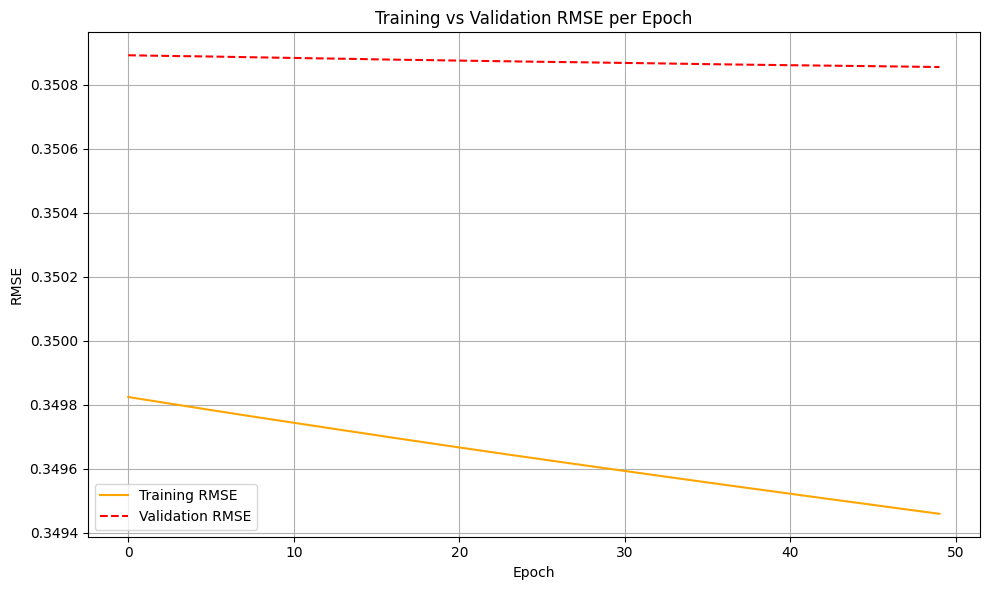

In [54]:
import matplotlib.pyplot as plt

# Misalnya ini adalah history dari model setelah training
# (pastikan 'history' adalah hasil dari model.fit(...))
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

plt.figure(figsize=(10, 6))
plt.plot(rmse, label='Training RMSE', color='orange')
plt.plot(val_rmse, label='Validation RMSE', color='red', linestyle='--')

plt.title('Training vs Validation RMSE per Epoch')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [55]:
!pip install tabulate

Proses uji coba model apakah bisa melakukan rekomendasi

In [56]:
from tabulate import tabulate
import numpy as np

# Input user ID secara manual
try:
    user_id = int(input("Masukkan User ID: "))
except ValueError:
    print("User ID harus berupa angka.")
    exit()

# Proses rekomendasi
encoded_user_id = user_to_user_encoded.get(user_id)

# Validasi jika user ID tidak ditemukan
if encoded_user_id is None:
    print(f"User ID {user_id} tidak ditemukan dalam data.")
    exit()

place_visited_by_user = rate[rate['User_Id'] == user_id]
place_not_visited = list(set(place_ids) - set(place_visited_by_user['Place_Id'].values))
place_not_visited_encoded = [place_to_place_encoded.get(x) for x in place_not_visited]

user_place_array = np.array([[encoded_user_id, place] for place in place_not_visited_encoded])
ratings = model.predict(user_place_array).flatten()
top_ratings_indices = ratings.argsort()[-7:][::-1]
recommended_place_ids = [place_encoded_to_place[place_not_visited_encoded[x]] for x in top_ratings_indices]

print('=' * 50)
print(f"Rekomendasi Tempat Wisata untuk User {user_id}")
print('=' * 50)

# Top 5 tempat yang pernah disukai
top_place_user = place_visited_by_user.sort_values(
    by='Place_Ratings', ascending=False).head(5)['Place_Id'].values
place_df_rows = point[point['Place_Id'].isin(top_place_user)]

top_visited_table = [
    [row['Place_Name'], row['Category'], row['Rating'], row['Price']]
    for _, row in place_df_rows.iterrows()
]
print("\nTempat yang Pernah Disukai:")
print(tabulate(top_visited_table, headers=["Nama Tempat", "Kategori", "Rating", "Harga"], tablefmt="fancy_grid"))

# Rekomendasi 7 tempat
recommended_place = point[point['Place_Id'].isin(recommended_place_ids)]
recommended_table = [
    [i + 1, row['Place_Name'], row['Category'], row['Rating'], row['Price']]
    for i, (_, row) in enumerate(recommended_place.iterrows())
]
print("\nRekomendasi Tempat:")
print(tabulate(recommended_table, headers=["#", "Nama Tempat", "Kategori", "Rating", "Harga"], tablefmt="fancy_grid"))


Masukkan User ID: 210
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Rekomendasi Tempat Wisata untuk User 210

Tempat yang Pernah Disukai:
╒═════════════════════════════╤═══════════════╤══════════╤═════════╕
│ Nama Tempat                 │ Kategori      │   Rating │   Harga │
╞═════════════════════════════╪═══════════════╪══════════╪═════════╡
│ Sumur Gumuling              │ Taman Hiburan │      4.5 │    7000 │
├─────────────────────────────┼───────────────┼──────────┼─────────┤
│ Hutan Pinus Pengger         │ Taman Hiburan │      4.5 │    3000 │
├─────────────────────────────┼───────────────┼──────────┼─────────┤
│ Watu Goyang                 │ Budaya        │      4.4 │    2500 │
├─────────────────────────────┼───────────────┼──────────┼─────────┤
│ Kampung Wisata Rejowinangun │ Budaya        │      4.3 │       0 │
╘═════════════════════════════╧═══════════════╧══════════╧═════════╛

Rekomendasi Tempat:
╒═════╤═══════════════════════════════════════╤═══════════════╤══════════╤═════════╕
│   #

# **Content Based Filtering**

ekstraksi fitur konten

In [57]:
indices = pd.Series(range(len(point)), index=point['Place_Id'])


melihat ukuran dari cosine, baris, dan key sampel

In [58]:
print(f"Jumlah baris point: {len(point)}")
print(f"Indices keys example: {list(indices.keys())[:10]}")
print(f"indices[{179}]: {indices.get(179)}")


Jumlah baris point: 126
Indices keys example: [85, 86, 87, 88, 89, 90, 91, 92, 93, 94]
indices[179]: 94


melihat key dari data yang dapat diujikan

In [59]:
print(point['Place_Id'].unique())


[ 85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138
 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156
 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174
 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192
 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210]


melihat isi data

In [60]:
point

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long
84,85,Taman Pintar Yogyakarta,Taman Pintar Yogyakarta (bahasa Jawa: Hanacara...,Taman Hiburan,Yogyakarta,6000,4.5,120.0,"{'lat': -7.800671500000001, 'lng': 110.3676551}",-7.800671,110.367655
85,86,Keraton Yogyakarta,Keraton Ngayogyakarta Hadiningrat atau Keraton...,Budaya,Yogyakarta,15000,4.6,NaN,"{'lat': -7.8052845, 'lng': 110.3642031}",-7.805284,110.364203
86,87,Sindu Kusuma Edupark (SKE),Sindu Kusuma Edupark (SKE) merupakan sebuah de...,Taman Hiburan,Yogyakarta,20000,4.2,120.0,"{'lat': -7.767297300000001, 'lng': 110.3542486}",-7.767297,110.354249
87,88,Museum Benteng Vredeburg Yogyakarta,Museum Benteng Vredeburg (bahasa Jawa: ꦩꦸꦱꦶꦪꦸꦩ...,Budaya,Yogyakarta,3000,4.6,120.0,"{'lat': -7.800201599999999, 'lng': 110.3663044}",-7.800202,110.366304
88,89,De Mata Museum Jogja,Museum De Mata merupakan salah satu museum yan...,Budaya,Yogyakarta,50000,4.4,NaN,"{'lat': -7.816315599999999, 'lng': 110.3871442}",-7.816316,110.387144
...,...,...,...,...,...,...,...,...,...,...,...
205,206,Wisata Kaliurang,"Jogja selalu menarik untuk dikulik, terlebih t...",Cagar Alam,Yogyakarta,8000,4.4,60.0,"{'lat': -7.6120675, 'lng': 110.4205209}",-7.612068,110.420521
206,207,Heha Sky View,HeHa Sky View adalah salah satu tempat wisata ...,Taman Hiburan,Yogyakarta,15000,4.4,120.0,"{'lat': -7.8496144, 'lng': 110.478324}",-7.849614,110.478324
207,208,Taman Sungai Mudal,"Taman Sungai Mudal, sebuah objek wisata alam t...",Cagar Alam,Yogyakarta,10000,4.6,150.0,"{'lat': -7.762813599999998, 'lng': 110.1161626}",-7.762814,110.116163
208,209,Pantai Sanglen,Pantai Sanglen. Lokasinya berada di Desa Kemad...,Bahari,Yogyakarta,10000,4.5,NaN,"{'lat': -8.1367456, 'lng': 110.5716362}",-8.136746,110.571636


In [61]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.4 MB/s eta 0:00:00


proses ekstraksi fitur dan mengambil skor similarity dari content based filtering

In [62]:
import re
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Fungsi preprocessing teks
def preprocess_text(text):
    text = text.lower()  # Ubah ke huruf kecil
    text = re.sub(r'[^\w\s]', '', text)  # Hapus tanda baca
    return text

# Gabungkan Description dan Category
point['combined_features'] = point['Description'].fillna('') + ' ' + point['Category'].fillna('')
descriptions = point['combined_features'].apply(preprocess_text)

# Gunakan stop words bahasa Indonesia
stopword_factory = StopWordRemoverFactory()
stop_words = stopword_factory.get_stop_words()
tfidf = TfidfVectorizer(stop_words=stop_words)
tfidf_matrix = tfidf.fit_transform(descriptions)
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

membuat fungsi rekomendasi yang mengambil id dan mengurutkan sesuai hasil skor similaritasnya dari tertinggi ke terendah dan hanya mengambil 5 sampel saja

In [63]:
def get_content_recommendations(place_id, cosine_sim=cosine_sim, top_n=5):
    """
    Mengembalikan top_n destinasi paling relevan berdasarkan kesamaan Cosine Similarity.

    Parameters:
    - place_id: ID destinasi acuan
    - cosine_sim: Matriks Cosine Similarity
    - top_n: Jumlah rekomendasi yang diinginkan (default 5)

    Returns:
    - DataFrame berisi top_n destinasi relevan, diurutkan berdasarkan skor kesamaan
    """
    if place_id not in indices:
        raise ValueError(f"Place_ID {place_id} tidak ditemukan.")

    idx = indices[place_id]
    # Ambil semua skor kesamaan untuk destinasi ini
    sim_scores = list(enumerate(cosine_sim[idx]))
    # Urutkan berdasarkan skor kesamaan (descending)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Ambil top_n destinasi (kecuali diri sendiri)
    sim_scores = sim_scores[1:top_n+1]

    # Ambil indeks destinasi yang relevan
    place_indices = [i[0] for i in sim_scores]

    # Kembalikan DataFrame dengan kolom relevan
    result = point.iloc[place_indices][['Place_Id', 'Place_Name', 'Category', 'Rating', 'Price']].copy()
    # Tambahkan kolom skor kesamaan
    result['Similarity_Score'] = [score[1] for score in sim_scores]

    return result

mengujikan ke salah satu id

In [64]:
# Contoh penggunaan
place_id = 210  # Misalnya, Pantai Congot
recommendations = get_content_recommendations(place_id)
print(f"Rekomendasi untuk Place_Id={place_id} ({point[point['Place_Id'] == place_id]['Place_Name'].iloc[0]}):")
print(recommendations.to_string(index=False))

Rekomendasi untuk Place_Id=210 (Pantai Congot):
 Place_Id        Place_Name Category  Rating  Price  Similarity_Score
      153      Pantai Kukup   Bahari     4.0  10000          0.328401
      168     Pantai Timang   Bahari     4.7  10000          0.322020
      157      Pantai Baron   Bahari     4.4  10000          0.310509
      191      Pantai Drini   Bahari     4.5  10000          0.309137
      200 Pantai Watu Kodok   Bahari     4.6   5000          0.293223


mengujikan ke id yang lain

In [65]:
# Contoh penggunaan
place_id = 179  # Misalnya, Pantai Congot
recommendations = get_content_recommendations(place_id)
print(f"Rekomendasi untuk Place_Id={place_id} ({point[point['Place_Id'] == place_id]['Place_Name'].iloc[0]}):")
print(recommendations.to_string(index=False))

Rekomendasi untuk Place_Id=179 (Candi Ratu Boko):
 Place_Id       Place_Name      Category  Rating  Price  Similarity_Score
      171        Candi Ijo        Budaya     4.6   5000          0.341665
      121  Candi Prambanan        Budaya     4.7  50000          0.279069
      193       Candi Sewu        Budaya     4.6  50000          0.260467
      104    Tebing Breksi        Budaya     4.4  20000          0.240145
       91 Situs Warungboto Taman Hiburan     4.4      0          0.163692


Mengevaluasi bagaimana skor recall yang dihasilkan

In [66]:
# Fungsi calculate_recall_at_5 yang dimodifikasi
def calculate_recall_at_5(place_id, recommendations):
    # Ambil hanya 5 rekomendasi teratas
    top_5_recommendations = recommendations.head(5)
    # Hitung jumlah item relevan dalam 5 rekomendasi teratas
    relevant_in_recommendations = top_5_recommendations[
        (top_5_recommendations['Category'] == point[point['Place_Id'] == place_id]['Category'].iloc[0]) &
        (top_5_recommendations['Rating'] >= 4.0)
    ].shape[0]
    # Recall@5 = proporsi item relevan dalam 5 rekomendasi
    recall = relevant_in_recommendations / 5
    return recall, relevant_in_recommendations

# Daftar Place_Id untuk evaluasi
place_ids_to_evaluate = [210, 179]  # Contoh: Pantai Congot dan Taman Sungai Mudal
recall_results = []

for place_id in place_ids_to_evaluate:
    # Dapatkan rekomendasi
    recommendations = get_content_recommendations(place_id)

    # Dapatkan kategori dan rating destinasi acuan
    acuan = point[point['Place_Id'] == place_id][['Place_Name', 'Category', 'Rating']].iloc[0]

    # Hitung Recall@5
    recall, relevant_in_recommendations = calculate_recall_at_5(place_id, recommendations)

    # Simpan hasil
    recall_results.append({
        'Place_Id': place_id,
        'Place_Name': acuan['Place_Name'],
        'Category': acuan['Category'],
        'Recall@5': recall,
        'Relevant_in_Recommendations': relevant_in_recommendations
    })

    # Cetak detail
    print(f"\nEvaluasi untuk Place_Id={place_id} ({acuan['Place_Name']}, Kategori: {acuan['Category']})")
    print("5 Rekomendasi Teratas:")
    print(recommendations.head(5)[['Place_Name', 'Category', 'Rating', 'Similarity_Score']].to_string(index=False))
    print(f"\nItem relevan dalam 5 rekomendasi teratas: {relevant_in_recommendations}")
    print(f"Recall@5: {recall:.2f}")

# Cetak rata-rata Recall@5
average_recall = sum([r['Recall@5'] for r in recall_results]) / len(recall_results)
print(f"\nRata-rata Recall@5: {average_recall:.2f}")

# Cetak ringkasan hasil
print("\nRingkasan Hasil Recall@5:")
for result in recall_results:
    print(f"Place_Id={result['Place_Id']} ({result['Place_Name']}): Recall@5={result['Recall@5']:.2f} "
          f"({result['Relevant_in_Recommendations']}/5)")


Evaluasi untuk Place_Id=210 (Pantai Congot, Kategori: Bahari)
5 Rekomendasi Teratas:
       Place_Name Category  Rating  Similarity_Score
     Pantai Kukup   Bahari     4.0          0.328401
    Pantai Timang   Bahari     4.7          0.322020
     Pantai Baron   Bahari     4.4          0.310509
     Pantai Drini   Bahari     4.5          0.309137
Pantai Watu Kodok   Bahari     4.6          0.293223

Item relevan dalam 5 rekomendasi teratas: 5
Recall@5: 1.00

Evaluasi untuk Place_Id=179 (Candi Ratu Boko, Kategori: Budaya)
5 Rekomendasi Teratas:
      Place_Name      Category  Rating  Similarity_Score
       Candi Ijo        Budaya     4.6          0.341665
 Candi Prambanan        Budaya     4.7          0.279069
      Candi Sewu        Budaya     4.6          0.260467
   Tebing Breksi        Budaya     4.4          0.240145
Situs Warungboto Taman Hiburan     4.4          0.163692

Item relevan dalam 5 rekomendasi teratas: 4
Recall@5: 0.80

Rata-rata Recall@5: 0.90

Ringkasan Hasil Rec